In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [67]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation",
           "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?")

# Display the first few rows of the dataset
print(data.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
from sklearn.preprocessing import LabelEncoder

# Handle missing values
data.dropna(inplace=True)

# Convert categorical data to numerical
label_encoders = {}
#le = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

print(data.head())
print(label_encoders)


   age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          5   77516          9             13               4   
1   50          4   83311          9             13               2   
2   38          2  215646         11              9               0   
3   53          2  234721          1              7               2   
4   28          2  338409          9             13               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     4    1          2174             0   
1           3             0     4    1             0             0   
2           5             1     4    1             0             0   
3           5             0     2    1             0             0   
4           9             5     2    0             0             0   

   hours-per-week  native-country  income  
0              40              38       0  
1              13              38       0  
2              40   

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [71]:
# Splitting the dataset into training and test sets
X = data.drop('income', axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [102]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [72]:
# Applying RFE
model = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence issues occur


# Instantiate RFE with the model and specify the number of features to select
rfe = RFE(estimator=model, n_features_to_select=8)
model.fit(X_train, y_train)

# Check which features were selected
print("Selected Features:", X_train.columns[rfe.support_])

Selected Features: Index(['age', 'workclass', 'education-num', 'marital-status', 'relationship',
       'race', 'sex', 'hours-per-week'],
      dtype='object')


In [73]:
# Continue with model training and evaluation using selected features
X_train_selected = X_train[X_train.columns[rfe.support_]]
X_test_selected = X_test[X_test.columns[rfe.support_]]

In [74]:
# Re-fit the logistic regression using only the selected features
model.fit(X_train_selected, y_train)

LogisticRegression(max_iter=1000)

In [75]:
# Predict on the test set
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

In [101]:
y_pred_proba

array([0.24874701, 0.11270476, 0.08749939, ..., 0.14766877, 0.41749566,
       0.80943175])

In [76]:
# Extract coefficients
coefficients = model.coef_[0] # Extract coefficients (for a single-class problem)
intercept = model.intercept_

#print("Coefficients:", coefficients) 
# Map coefficients to feature names
feature_names = X_train.columns
features_coefficients = zip(feature_names, coefficients)

# Convert to a dictionary or print directly
coefficients_dict = dict(features_coefficients)
print("Coefficients with Feature Names:")
for feature, coeff in coefficients_dict.items():
    print(f"{feature}: {coeff}")
    
print("Intercept:", intercept)

Coefficients with Feature Names:
age: 0.04099788805528269
workclass: -0.11169912855298783
fnlwgt: 0.3571802766234019
education: -0.2059727021452469
education-num: -0.11118628823594093
marital-status: 0.11142709612133753
occupation: 0.9344252287025655
relationship: 0.032144210458433506
Intercept: [-8.1877478]


In [77]:
# Calculate AUC
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {roc_auc}")

AUC: 0.8221431501082945


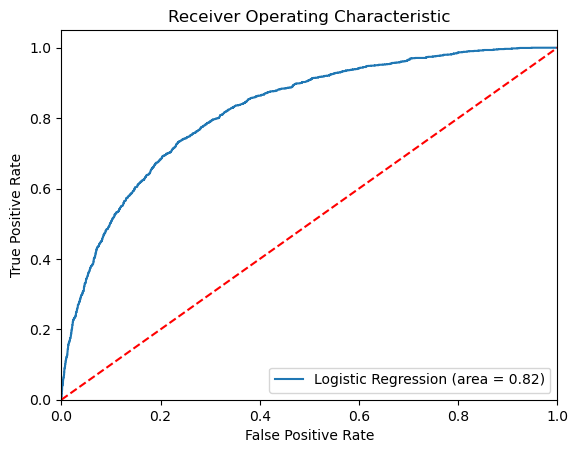

In [78]:
# Plot ROC Curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### ROC Curve Overview:
The ROC curve is a graphical representation that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots two parameters:

- True Positive Rate (TPR): On the y-axis, TPR is also known as sensitivity, recall, or probability of detection. It measures the proportion of actual positives that are correctly identified as such.
- False Positive Rate (FPR): On the x-axis, FPR is one minus the specificity. It measures the proportion of actual negatives that are incorrectly identified as positives.

### Curve and Diagonal Line:

- The blue line represents the logistic regression model's performance. The closer this line is to the top-left corner of the graph, the better the model's capability to distinguish between the classes.
- The dashed red line represents a random guess. A classifier with no discriminative power would produce a point lying along this line, which corresponds to a 50/50 chance of predicting a positive or negative class.

### AUC Interpretation:

- The AUC value of 0.82 indicates that there is an 82% chance that the model will be able to distinguish between a positive and a negative instance. In general, an AUC value of:
  - 0.5 suggests no discriminative ability (same as random guessing).
  - 0.6 to 0.7 is considered poor.
  - 0.7 to 0.8 is considered fair.
  - 0.8 to 0.9 is considered good.
  - 0.9 to 1.0 is considered excellent.

### Model Performance:

Given an AUC of 0.82, your logistic regression model has good discriminative ability. It is quite effective at classifying the positive class in this dataset, with a relatively low rate of false positives as indicated by the curve's shape and its position relative to the diagonal line.

This ROC curve is a useful tool for evaluating the performance of your logistic regression model and for comparing its effectiveness to other classification models. If you have multiple models, the one with the ROC curve closest to the top-left corner and the highest AUC is generally the best performer.

### Example Scenario:

Imagine we have a dataset of 100 people who are tested for a disease. Let’s assume the reality of these 100 people is:

- 30 people actually have the disease (positives).
- 70 people do not have the disease (negatives).

Now, consider a test that tries to predict who has the disease and who does not.

Test Outcomes:
- The test correctly identifies 25 of the people who have the disease (True Positives).
- The test incorrectly identifies 15 people who do not have the disease as having it (False Positives).
- The test correctly identifies 55 people who do not have the disease as not having it (True Negatives).
- The test fails to identify 5 people who actually have the disease (False Negatives).

Calculating TPR and FPR:
- True Positive Rate (TPR): True Positives/Actual Positives = 25/30 (approx 83% (0.83)). This means the test correctly identifies 83% of the people who actually have the disease.
- False Positive Rate (FPR): False Positives/Actual Negatives = 15/70 (approx 21% (0.21)).This indicates that 21% of the healthy people are incorrectly diagnosed by the test as having the disease.

Interpretation:
- TPR (83%): Higher is better. It reflects the test's ability to correctly identify those with the disease. A high TPR is particularly important in medical diagnostics, where missing a sick patient can be critical.
- FPR (21%): Lower is better. It reflects how many false alarms are raised by the test. A low FPR is crucial to avoid unnecessary treatment for non-diseased individuals.

These metrics help us evaluate the accuracy of diagnostic tests and classification models, balancing the need to detect positives accurately without raising too many false alarms.

In [79]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Algorithms to use in the optimization problem
}

In [80]:
# Setup GridSearchCV
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

In [81]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy', verbose=1)

In [82]:
# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'solver': 'newton-cg'}


In [83]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)



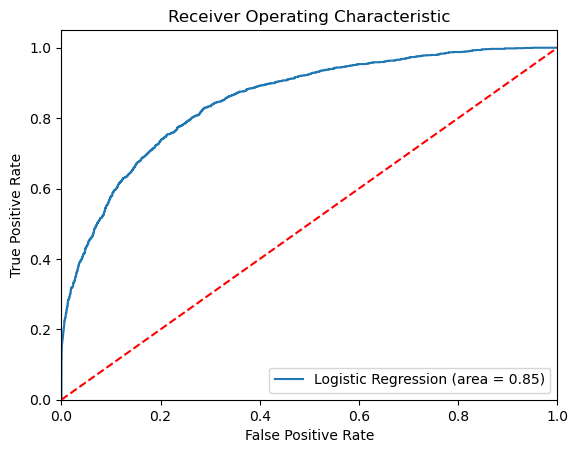

In [84]:
# Plot ROC Curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### newton-cg (Newton's Method)
- Full Name: Newton-Conjugate Gradient
- Characteristics:
  - It uses a Newton-Raphson approach which approximates the loss function using a second-order Taylor series expansion.
  - It computes the Hessian matrix (second-order partial derivatives) to find the step direction.
  - Suitable for large datasets because it converges faster when close to the minimum (quadratic convergence).
- Use Cases:
  - Good for multiclass problems as it supports multinomial logistic regression.
  - Efficient for datasets with a large number of features, but can be slow if the number of features is extremely large because it needs to compute and invert a large Hessian matrix.
- Limitations:
  - Requires more memory and computational power to calculate the Hessian, especially with very large feature sets.

### lbfgs (Limited-memory Broyden-Fletcher-Goldfarb-Shanno)
- Characteristics:
  - It is an approximation of the Broyden-Fletcher-Goldfarb-Shanno (BFGS) optimization algorithm, which uses a limited amount of memory.
  - It approximates the Hessian matrix, retaining only a few vectors that represent the gradients of previous steps to reduce memory use.
  - It is robust and effective in handling a wide variety of problems.
- Use Cases:
  - Suitable for both small and medium-sized datasets.
  - It supports both binary and multiclass problems.
  - It is the default solver in Scikit-Learn’s logistic regression implementation, recommended for a good balance between speed and accuracy.
- Limitations:
  - Might not be the best choice for extremely large datasets because, while it is more memory-efficient than newton-cg, it still requires more computation than some other methods.

### liblinear (Library for Large Linear Classification)
- Characteristics:
  - It uses a coordinate descent (CD) algorithm, which updates model coefficients for one feature at a time to minimize the cost function.
  - It's very efficient for high-dimensional datasets, but only solves binary classification problems natively. For multiclass problems, a one-vs-rest scheme is applied.
- Use Cases:
  - Best for large sparse datasets with high dimensionality.
  - It's particularly well-suited for problems with thousands to millions of features where data sparsity is an issue.M
- Limitations:
  - Not suitable for non-linear problems since it doesn’t support multinomial logistic regression.
  - It might converge slowly if the number of features is very large relative to the number of samples.
- Choosing the Right Solver:
  - For small to medium datasets where computational resources are not a limiting factor, newton-cg or lbfgs can be effective, especially if you need to solve a multiclass problem directly.
  - For very large datasets or when dealing with binary classification, liblinear is often a strong choice due to its efficiency with high-dimensional data.

lbfgs is generally a good default choice for a variety of problems, balancing memory usage and convergence speed.
When choosing a solver, also consider the nature of your data and problem, as well as the computational resources available. It might also be useful to experiment with different solvers to see which provides the best performance for your specific application.

In [85]:
import statsmodels.api as sm

# Assuming X and y are defined as your features and target variable

# Add a constant to the features, as statsmodels does not add it by default
X_train_constant = sm.add_constant(X_train)

# Fit the model
model_sm = sm.Logit(y_train, X_train_constant).fit()

# Print the model summary
print(model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.389947
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                24129
Model:                          Logit   Df Residuals:                    24114
Method:                           MLE   Df Model:                           14
Date:                Sat, 01 Jun 2024   Pseudo R-squ.:                  0.3023
Time:                        03:01:55   Log-Likelihood:                -9409.0
converged:                       True   LL-Null:                       -13486.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.2066      0.229    -35.852      0.000      -8.655      -7.758
age              

In [86]:
# Coefficients
coefficients = model_sm.params
print("Coefficients:\n", coefficients)

# AIC and BIC
aic = model_sm.aic
bic = model_sm.bic
print("AIC:", aic)
print("BIC:", bic)

# P-values
p_values = model_sm.pvalues
print("P-values:\n", p_values)


Coefficients:
 const            -8.206581e+00
age               3.704167e-02
workclass        -1.199963e-01
fnlwgt            4.073152e-07
education         1.339960e-02
education-num     3.359464e-01
marital-status   -2.178918e-01
occupation        3.570569e-03
relationship     -1.173746e-01
race              1.161822e-01
sex               9.274470e-01
capital-gain      3.114095e-04
capital-loss      6.556308e-04
hours-per-week    3.029540e-02
native-country    6.452157e-05
dtype: float64
AIC: 18848.039648194015
BIC: 18969.407193927596
P-values:
 const             1.686567e-281
age               7.497684e-118
workclass          5.812321e-11
fnlwgt             1.975285e-02
education          2.442256e-02
education-num      0.000000e+00
marital-status     1.070024e-53
occupation         4.325094e-01
relationship       1.220559e-12
race               2.587277e-06
sex                4.586661e-57
capital-gain      1.092857e-172
capital-loss       3.593172e-63
hours-per-week     7.455769e-7

In [87]:
from sklearn.metrics import precision_recall_curve, f1_score

# Assume y_test and y_pred_proba are already defined
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the threshold corresponding to the maximum F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold based on F1 score:", optimal_threshold)


Optimal threshold based on F1 score: 0.31109372887360953


In [88]:
from sklearn.metrics import precision_recall_curve, auc

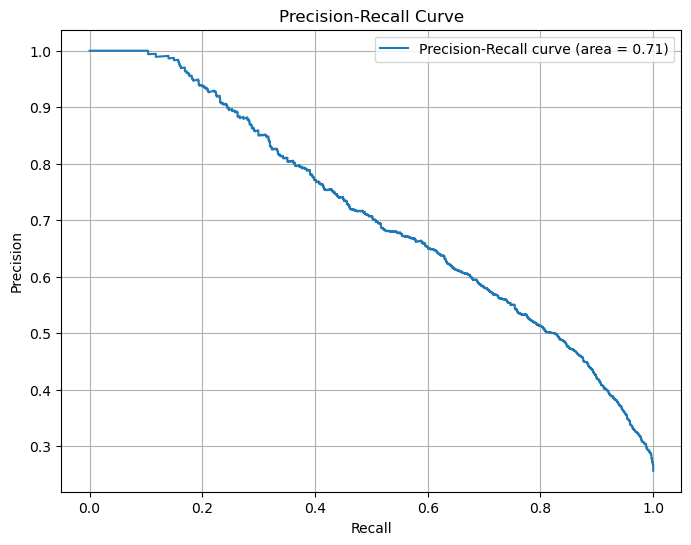

In [89]:
# Assuming y_test are your true labels and y_pred_proba are the predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate the area under the curve as a summary statistic
area = auc(recall, precision)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (area = {area:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

- Precision and Recall: These are calculated for each possible threshold (which are the scores returned by your model). The precision_recall_curve function returns a list of precision and recall values for each threshold.
- Plot: The x-axis represents recall, and the y-axis represents precision. Each point on the curve represents a different threshold value, starting from the lowest threshold on the right (high recall, low precision) to the highest threshold on the left (low recall, high precision).
- Area Under the Curve (AUC): This is also computed to give a single measure of performance across all thresholds. A higher area under the curve indicates both high recall and high precision.
- When to Use:
Precision-Recall curves are especially useful when dealing with imbalanced datasets where the positive class (the minority class) is more important. This is common in scenarios like fraud detection or rare disease identification, where false negatives (failing to detect an actual positive case) have more severe consequences than false positives.

This visualization helps in selecting a threshold that balances precision and recall according to your specific needs, potentially guiding decisions on how to manage the trade-off between catching as many positives as possible (high recall) and making sure the positive predictions are correct (high precision).

## Prediction

In [96]:
# Example new data point
new_data = pd.DataFrame([{
    'age': 52,
    'workclass': 5,
    #'fnlwgt': 209642,
    'education-num': 9,
    'marital-status': 4,
    #'occupation': 0,
    'relationship': 1,
    'race': 4,
    'sex': 1,
    #'capital-gain': 0,
    #'capital-loss': 0,
    'hours-per-week': 45,
    #'native-country': 38
}])

In [97]:
# Make a prediction
new_prediction = model.predict(new_data)
new_prediction_proba = model.predict_proba(new_data)

print("Predicted class for the new data point:", new_prediction)
print("Probability estimates for each class for the new data point:", new_prediction_proba)

Predicted class for the new data point: [0]
Probability estimates for each class for the new data point: [[0.81879204 0.18120796]]
